In [1]:
#Packages required for the cleaning data
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('basics').getOrCreate()
spark = SparkSession.builder.appName('missing').getOrCreate() # for cleaning data
spark = SparkSession.builder.appName('linear_regression_adv').getOrCreate()
spark = SparkSession.builder.appName('linear_regression_docs').getOrCreate()
spark = SparkSession.builder.appName('logistic_regression_adv').getOrCreate()
spark = SparkSession.builder.appName('logistic_regression_docs').getOrCreate()
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
#Packages import for data exploration and cleaning
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
#import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pyspark.sql.functions import isnan
from pyspark.sql.functions import col, sum
from pyspark.sql import *
from pyspark.ml.classification import LogisticRegression


In [2]:
# Importing dataset of the flight delays in 2009, dataset contains its own headings
df = spark.read.csv('Flight.csv', header=True, inferSchema=True)


In [3]:
#using pandas to explore the data set
pd.DataFrame(df.take(6), columns = df.columns).transpose()

,0,1,2,3,4,5
FlightNum,7826,7826,2866,2866,7248,5315
CRSElapsedTime,154,154,117,117,105,106
AirTime,119,120,103,106,76,68
ArrDelay,257,261,22,32,178,367
DepDelay,225,225,9,9,185,365
Distance,834,834,599,599,599,596
TaxiIn,5,7,4,4,4,10
TaxiOut,62,63,23,30,18,30
CarrierDelay,0,225,22,32,178,0
WeatherDelay,0,0,0,0,0,0


In [4]:

print(df.head())
df.printSchema()

Row(FlightNum=7826, CRSElapsedTime=154, AirTime=119, ArrDelay=257, DepDelay=225, Distance=834, TaxiIn=5, TaxiOut=62, CarrierDelay=0, WeatherDelay=0, NASDelay=32, SecurityDelay=0, LateAircraftDelay=225)
root
 |-- FlightNum: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- WeatherDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)



In [5]:
# Import VectorAssembler and Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['FlightNum', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], outputCol = 'features')
vector_output = vector_assembler.transform(df)
vector_output.printSchema()
vector_output.head(1)

root
 |-- FlightNum: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: integer (nullable = true)
 |-- TaxiOut: integer (nullable = true)
 |-- CarrierDelay: integer (nullable = true)
 |-- WeatherDelay: integer (nullable = true)
 |-- NASDelay: integer (nullable = true)
 |-- SecurityDelay: integer (nullable = true)
 |-- LateAircraftDelay: integer (nullable = true)
 |-- features: vector (nullable = true)



[Row(FlightNum=7826, CRSElapsedTime=154, AirTime=119, ArrDelay=257, DepDelay=225, Distance=834, TaxiIn=5, TaxiOut=62, CarrierDelay=0, WeatherDelay=0, NASDelay=32, SecurityDelay=0, LateAircraftDelay=225, features=DenseVector([7826.0, 154.0, 119.0, 257.0, 225.0, 834.0, 5.0, 62.0, 0.0, 0.0, 32.0, 0.0, 225.0]))]

In [6]:
# Because the features have been combined into one vector, we no longer need them
vector_output = vector_output.select(['features', 'ArrDelay'])
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([7826.0, 154.0, 119.0, 257.0, 225.0, 834.0, 5.0, 62.0, 0.0, 0.0, 32.0, 0.0, 225.0]), ArrDelay=257)]
+--------------------+--------+
|            features|ArrDelay|
+--------------------+--------+
|[7826.0,154.0,119...|     257|
|[7826.0,154.0,120...|     261|
|[2866.0,117.0,103...|      22|
+--------------------+--------+
only showing top 3 rows



In [7]:
# Let's do a randomised 70/30 split. Remember, you should explain why you chose a particular split. 
train_data,test_data = vector_output.randomSplit([0.8,0.2])
train_data.describe().show()
test_data.describe().show()

+-------+-----------------+
|summary|         ArrDelay|
+-------+-----------------+
|  count|            96722|
|   mean|63.04608051942681|
| stddev|59.04295337065486|
|    min|               15|
|    max|             1357|
+-------+-----------------+

+-------+------------------+
|summary|          ArrDelay|
+-------+------------------+
|  count|             24064|
|   mean|63.051363031914896|
| stddev| 59.54003084518404|
|    min|                15|
|    max|              1525|
+-------+------------------+



In [8]:
# Importing the LR package.
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol='features', labelCol='ArrDelay')
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept) + "\n")
training_summary = lr_model.summary
print("RMSE: " + str(training_summary.rootMeanSquaredError))
print("R2: " + str(training_summary.r2))

Coefficients: [-2.917101681725377e-10,-0.13885515618779506,0.1388551740851702,0.5135855038305539,0.1388549114154339,5.069985739686348e-09,0.13885511043097667,0.1388549196402357,0.34755945819723105,0.3475595485366691,0.3475595212149803,0.3475594166416849,0.3475596182124125]
Intercept: 4.853297584147876e-06

RMSE: 0.001093609257996759
R2: 0.9999999996569221


In [9]:
train_data.describe().show()

+-------+-----------------+
|summary|         ArrDelay|
+-------+-----------------+
|  count|            96722|
|   mean|63.04608051942681|
| stddev|59.04295337065486|
|    min|               15|
|    max|             1357|
+-------+-----------------+



In [10]:
# Let's evaluate the model against the test data.
test_results = lr_model.evaluate(test_data)
print("RMSE on test data: " + str(test_results.rootMeanSquaredError))
print("R2 on test data: " + str(test_results.r2))

RMSE on test data: 8.303491271925968e-06
R2 on test data: 0.9999999999999806


#Logistics Regression

In [11]:
# Import the relevant packages.
# Because the features have been combined into one vector, we no longer need them. Below we select the features and label.
vector_output = vector_output.select(['features', 'ArrDelay'])
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([7826.0, 154.0, 119.0, 257.0, 225.0, 834.0, 5.0, 62.0, 0.0, 0.0, 32.0, 0.0, 225.0]), ArrDelay=257)]
+--------------------+--------+
|            features|ArrDelay|
+--------------------+--------+
|[7826.0,154.0,119...|     257|
|[7826.0,154.0,120...|     261|
|[2866.0,117.0,103...|      22|
+--------------------+--------+
only showing top 3 rows



In [12]:
#pipeline_model = pipeline.fit(df)
#pipeline_model = pipeline.fit(df)
#df_pipe = pipeline_model.transform(df)
#df_pipe = df_pipe.select('ArrDelay', 'features')

In [13]:
train_data,test_Data = vector_output.randomSplit([0.8,0.2])

In [14]:
from pyspark.ml.classification import LogisticRegression

# Split our data. Note that the new DataFrame is being used.
train_data, test_Data = df.randomSplit([0.8,0.2])
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_Data.count()))

Training Dataset Count: 96643
Test Dataset Count: 24143


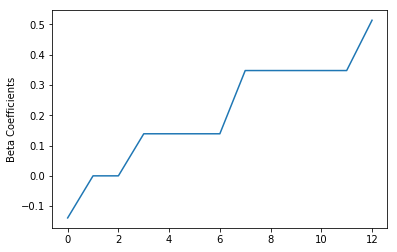

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.regression import AFTSurvivalRegression
from pyspark.ml.linalg import Vectors
# Visualising the coefficients. Sort from lowest to highest.
beta = np.sort(lr_model.coefficients)

# Plot the data.
plt.plot(beta)

# Add a label to the data.
plt.ylabel('Beta Coefficients')

# Show the graph. 
plt.show()

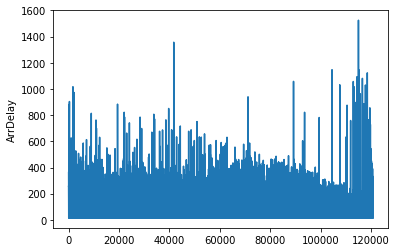

In [16]:
# Convert DataFrame to Pandas DataFrame.
df = df.toPandas()

# Plot model recall and precision.
plt.plot(df['ArrDelay'])

# Define the labels and show the graph. 
plt.ylabel('ArrDelay')
#plt.xlabel('Recall')
plt.show()

In [17]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [18]:
#Automatically identify categorical features, and index them.
#Set maxCategories so features with > 4 distinct values are treated as continuous.
# Import VectorAssembler and Vectors
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = ['FlightNum', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], outputCol = 'features')
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(df)
vector_output = vector_assembler.transform(df)
vector_output.printSchema()
vector_output.head(1)


AttributeError: 'DataFrame' object has no attribute '_jdf'

In [ ]:
(trainingData, testData) = df.randomSplit([0.8, 0.2])

In [ ]:
rf = RandomForestRegressor(featuresCol="indexedFeatures")

In [ ]:
predictions = vector_assembler.transform(df)

In [ ]:
predictions.select("prediction", "ArrDelay", "features").show(5)

In [ ]:

// Split the data into training and test sets (30% held out for testing).
val Array(trainingData, testData) = data.randomSplit(Array(0.7, 0.3))

// Train a GBT model.
val gbt = new GBTRegressor()
  .setLabelCol("label")
  .setFeaturesCol("indexedFeatures")
  .setMaxIter(10)

// Chain indexer and GBT in a Pipeline.
val pipeline = new Pipeline()
  .setStages(Array(featureIndexer, gbt))

// Train model. This also runs the indexer.
val model = pipeline.fit(trainingData)

// Make predictions.
val predictions = model.transform(testData)

// Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

// Select (prediction, true label) and compute test error.
val evaluator = new RegressionEvaluator()
  .setLabelCol("label")
  .setPredictionCol("prediction")
  .setMetricName("rmse")
val rmse = evaluator.evaluate(predictions)
println("Root Mean Squared Error (RMSE) on test data = " + rmse)

val gbtModel = model.stages(1).asInstanceOf[GBTRegressionModel]
println("Learned regression GBT model:\n" + gbtModel.toDebugString)